## Assignment 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
yeast = pd.read_csv('data/yeast.data', sep = '\s+', header = None)
col_names = ['v{}'.format(i) for i in range(0, 9)]
col_names.append('y') 
yeast.columns = col_names
yeast.rename(columns={yeast.columns[0]: 'Source'}, inplace = True)
yeast.head()

,Source,v1,v2,v3,v4,v5,v6,v7,v8,y
0,ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
1,ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
2,ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
3,AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
4,AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


In [3]:
x = yeast.iloc[:, 1:9]
y = np.array(yeast['y']).reshape(-1, 1)

In [4]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder()
y = enc.fit_transform(y)
y = y.toarray()

## Ourlier Detection

Outlier detectot to be used:
- LOF: Local Outlier Factor
- One class SVM
- Isolation Forest

In [5]:
#sns.pairplot(yeast.iloc[:,1:10], hue = 'y')
#plt.savefig('pics/pair.png')

### One class SVM

In [6]:
from sklearn.svm import OneClassSVM
clf = OneClassSVM(gamma = 'auto')
outlier = clf.fit_predict(x)

In [7]:
pd.Series(outlier).value_counts()

 1    743
-1    741
dtype: int64

Any data labeled by -1 is treated as an outlier using the method. 

### LOF

In [8]:
from sklearn.neighbors import LocalOutlierFactor as LOF

In [91]:
lof = LOF()
outlier1 = lof.fit_predict(x)
pd.Series(outlier1).value_counts()

/Users/yry/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


 1    1335
-1     149
dtype: int64

### Isolation Forest

In [89]:
from sklearn.ensemble import IsolationForest

In [90]:
clf = IsolationForest()
outlier2 = clf.fit_predict(x)
pd.Series(outlier2).value_counts()

/Users/yry/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/Users/yry/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/Users/yry/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


 1    1335
-1     149
dtype: int64

### Remove outlier

In [29]:
y_ = y[np.where(outlier1 == 1)[0],]
y_.shape

(1335, 10)

In [30]:
x_ = x.iloc[np.where(outlier1 == 1)[0],].reset_index(drop = True)
y_ = y[np.where(outlier1 == 1)[0],]
y_.shape

(1335, 10)

## Build up ANN model.

In [31]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Activation
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [100]:
scalar = MinMaxScaler()
x_ = scalar.fit_transform(x_)

In [123]:
x_tr, x_te, y_tr, y_te = train_test_split(x_, y_,  test_size = 0.34, random_state = 256)
tr = y_tr.argmax(axis = 1)
te = y_te.argmax(axis = 1)

In [124]:
def get_err(pred_tr, pred_te):
    matrix_tr = confusion_matrix(tr, pred_tr)
    matrix_te = confusion_matrix(te, pred_te)
    err_tr = 1 - (matrix_tr[0,0]+matrix_tr[1:, 1:].sum()) / matrix_tr.sum()
    err_te = 1 - (matrix_te[0,0]+matrix_te[1:, 1:].sum()) / matrix_te.sum()
    return err_tr, err_te
get_err(np.random.randint(0, 7, y_tr.shape[0]), np.random.randint(0, 7, y_te.shape[0]))

(0.3688989784335982, 0.35462555066079293)

In [149]:
class call_weight(keras.callbacks.Callback):
    '''
    This class is to help me track the wieght of the last layer using a 
    keras sequence
    '''
    # Def my own callback class so I can track the weight.
    def on_train_begin(self,logs = {}):
        self.weights = []
    def on_train_batch_end(self, batch, logs = {}):
        w = self.model.layers[2].get_weights()
        w_arr =[w[1][ 1]]
        w_arr.extend(list(w[0][:,1]))
        #self.weights.append(self.model.layers[2].get_weights())
        self.weights.append(w_arr)

class call_err(keras.callbacks.Callback):
    def on_train_begin(self, logs = {}):
        self.err_tr = []
        self.err_te = []
    
    def on_epoch_end(self,batch, logs = {}):
        pred_tr = self.model.predict(x_tr).argmax(axis = 1)
        pred_te = self.model.predict(x_te).argmax(axis = 1)
        err_tr, err_te = get_accu(pred_tr, pred_te)
        self.err_tr.append(err_tr)
        self.err_te.append(err_te)
    
class call_loss(keras.callbacks.Callback):
    '''
    This class is to track losses.
    '''
    def on_train_begin(self, logs = {}):
        self.losses = []

    def on_train_batch_end(self, batch,  logs = {}):
        # print(logs)
        self.losses.append(logs.get('loss'))
                                         
# Build up the sequential model.     
MLP = Sequential([
    Dense(3, input_shape =(8,), activation = tf.nn.sigmoid ,kernel_initializer = tf.initializers.RandomUniform),
    # First hidden layer:
    Dense(3, activation = tf.nn.sigmoid, kernel_initializer = tf.initializers.RandomUniform),
    # Second hidden layer:
    Dense(10, activation = tf.nn.sigmoid, kernel_initializer= tf.initializers.RandomUniform)
    #Activation(activation = tf.nn.sigmoid)
    ])

# Initialize the trackers.
weight_tracker = call_weight()
loss_tracker = call_loss()
err_tracker = call_err()

# Compile and fit.
MLP.compile(optimizer = keras.optimizers.SGD(learning_rate = 3.5), loss = 'mse', metrics = ['accuracy'])

history = MLP.fit(x_tr,y_tr, epochs = 100, batch_size = 128,verbose = 2, callbacks = [weight_tracker, loss_tracker, err_tracker])


Train on 881 samples
Epoch 1/100
881/881 - 0s - loss: 0.1905 - accuracy: 0.2690
Epoch 2/100
881/881 - 0s - loss: 0.1202 - accuracy: 0.3167
Epoch 3/100
881/881 - 0s - loss: 0.0978 - accuracy: 0.3167
Epoch 4/100
881/881 - 0s - loss: 0.0891 - accuracy: 0.3167
Epoch 5/100
881/881 - 0s - loss: 0.0851 - accuracy: 0.3167
Epoch 6/100
881/881 - 0s - loss: 0.0829 - accuracy: 0.3167
Epoch 7/100
881/881 - 0s - loss: 0.0815 - accuracy: 0.3167
Epoch 8/100
881/881 - 0s - loss: 0.0807 - accuracy: 0.3167
Epoch 9/100
881/881 - 0s - loss: 0.0801 - accuracy: 0.3167
Epoch 10/100
881/881 - 0s - loss: 0.0796 - accuracy: 0.3167
Epoch 11/100
881/881 - 0s - loss: 0.0793 - accuracy: 0.3167
Epoch 12/100
881/881 - 0s - loss: 0.0791 - accuracy: 0.3167
Epoch 13/100
881/881 - 0s - loss: 0.0789 - accuracy: 0.3167
Epoch 14/100
881/881 - 0s - loss: 0.0787 - accuracy: 0.3167
Epoch 15/100
881/881 - 0s - loss: 0.0785 - accuracy: 0.3167
Epoch 16/100
881/881 - 0s - loss: 0.0784 - accuracy: 0.3167
Epoch 17/100
881/881 - 0s - 

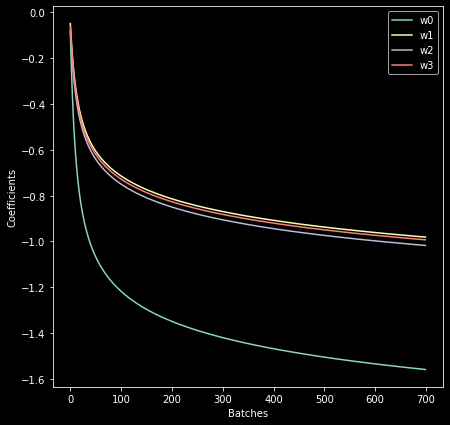

<Figure size 432x288 with 0 Axes>

In [150]:
w = np.array(weight_tracker.weights)
w0 = w[:, 0]
w1 = w[:, 1]
w2 = w[:, 2]
w3 = w[:, 3]
plt.figure(figsize = (7,7))
plt.plot(w0, label = 'w0')
plt.plot(w1, label = 'w1')
plt.plot(w2, label = 'w2')
plt.plot(w3, label = 'w3')
plt.legend()
plt.xlabel('Batches')
plt.ylabel('Coefficients')
plt.show()
plt.savefig('pics/weight.png')

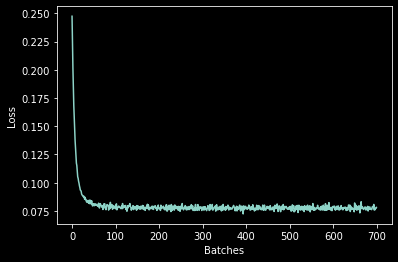

In [151]:
plt.plot(loss_tracker.losses)
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.savefig('pics/loss.png')
plt.show()

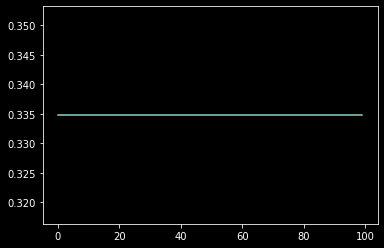

In [152]:
plt.plot(err_tracker.err_te)

In [148]:
MLP.predict(x_te).argmax(axis = 1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Re-train ANN model with all data 

In [85]:
history= MLP.fit(x_, y_, epochs = 20, batch_size = 32,verbose = 2, callbacks = [weight_tracker, loss_tracker, accu_tracker])

Train on 1335 samples
Epoch 1/20
1335/1335 - 3s - loss: 0.0772 - accuracy: 0.3043
Epoch 2/20
1335/1335 - 3s - loss: 0.0772 - accuracy: 0.2609
Epoch 3/20
1335/1335 - 3s - loss: 0.0772 - accuracy: 0.3043
Epoch 4/20
1335/1335 - 6s - loss: 0.0771 - accuracy: 0.3913
Epoch 5/20
1335/1335 - 3s - loss: 0.0774 - accuracy: 0.3043
Epoch 6/20
1335/1335 - 3s - loss: 0.0772 - accuracy: 0.2609
Epoch 7/20
1335/1335 - 3s - loss: 0.0772 - accuracy: 0.3043
Epoch 8/20
1335/1335 - 3s - loss: 0.0773 - accuracy: 0.3913
Epoch 9/20
1335/1335 - 3s - loss: 0.0770 - accuracy: 0.3043
Epoch 10/20
1335/1335 - 3s - loss: 0.0770 - accuracy: 0.5652
Epoch 11/20
1335/1335 - 3s - loss: 0.0773 - accuracy: 0.3913
Epoch 12/20
1335/1335 - 3s - loss: 0.0772 - accuracy: 0.3043
Epoch 13/20
1335/1335 - 3s - loss: 0.0772 - accuracy: 0.3913
Epoch 14/20
1335/1335 - 3s - loss: 0.0771 - accuracy: 0.3043
Epoch 15/20
1335/1335 - 3s - loss: 0.0772 - accuracy: 0.3478
Epoch 16/20
1335/1335 - 3s - loss: 0.0772 - accuracy: 0.1739
Epoch 17/20